In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import obonet
import BOCC
import pandas as pd
import numpy as np
import math
from webweb import Web
import os
import seaborn as sns
from BOCC import BOCC, load_clusters
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import typing
import matplotlib.patches as mpatches
from upsetplot import from_memberships
from upsetplot import plot
import random
import pickle


std_fontsize = 12

In [26]:
G19 = nx.read_edgelist('../Edgelists/String_HPO_2019.phenotypic_branch.edgelist.txt')
G20 = nx.read_edgelist('../Edgelists/String_HPO_2020.phenotypic_branch.edgelist.txt')
G21 = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
G22 = nx.read_edgelist('../Edgelists/String_HPO_2022.phenotypic_branch.edgelist.txt')

def remove_trivial_coms(coms):
    keepers = []
    for c in coms:
        if len(c.members) > 2 and len(c.get_genes()) > 0 and len(c.get_genes()) != len(c.members):
            keepers.append(c)
    return keepers

g_subcoms = load_clusters('../SubComs/2019/paris.greedy.2019.coms.txt')
g_subcoms = remove_trivial_coms(g_subcoms)

In [27]:
def get_possible_pairs_from_com(coms,G):
    # this function returns a list of all possible pairings of genes and phenotypes in all clusters - regardless of if they exist or not
    pairs = []
    for com in coms:
        pairs.append(set())
        genes = [x for x in com.members if 'HP:' not in x]
        hpos = [x for x in com.members if 'HP:' in x]
#         print('HPOs',len(hpos))
#         print('Genes',len(genes))
        for g in genes:
            for h in hpos:
                p=[g,h]
                # check if p in in G
                if G.has_edge(p[0],p[1]):
                    continue
                p.sort()
                pairs[-1].add(str(p))
    return pairs

def get_possible_pairs_from_com_non_bocc(com,G):
    # this function returns a list of all possible pairings of genes and phenotypes in all clusters - regardless of if they exist or not
    pairs = set()
    genes = [x for x in com if 'HP:' not in x]
    hpos = [x for x in com if 'HP:' in x]
#         print('HPOs',len(hpos))
#         print('Genes',len(genes))
    for g in genes:
        for h in hpos:
            p=[g,h]
            # check if p in in G
            if G.has_edge(p[0],p[1]):
                continue
            p.sort()
            pairs.add(str(p))
    return pairs

def load_new_edges(el,G):
    pairs = set()
    for line in open(el,'r'):
        row = line.strip().split('\t')
        row.sort()
        if G.has_edge(row[0],row[1]):
            continue
        pairs.add(str(row))
    return pairs

# load new edges but shuffle them
def load_new_edges_shuffled(el, seed=None):
    pairs = set()
    genes = []
    hpos = []
    rows = 0
    for line in open(el,'r'):
        row = line.strip().split('\t')
        # add the HPO term to the list of HPO terms
        if 'HP:' in row[0]:
            hpos.append(row[0])
            genes.append(row[1])
        else:
            genes.append(row[0])
            hpos.append(row[1])
        rows += 1
    # shuffle the genes and hpos
    np.random.seed(seed)
    np.random.shuffle(genes)
    np.random.shuffle(hpos)
    # create the pairs
    for i in range(len(genes)):
        p = [genes[i],hpos[i]]
        p.sort()
        pairs.add(str(p))
    return pairs
    

def rediscover(pairs, el_pairs):
    # find the intersection
    results = []
    for com_pairs in pairs:
        results.append(len(com_pairs.intersection(el_pairs)))
    return results

In [28]:
def edge_shuffle_pvalue(current_subcoms, current_G, future_el, name, n=1000):
    # get the possible pairs
    com_pairs = get_possible_pairs_from_com(current_subcoms,current_G)
    print(name,len(com_pairs))

    # load the new edges
    el_pairs = load_new_edges(el=future_el, G=current_G)
    # print('2020',len(el_pairs))

    # score the cluster's rediscoveries
    rediscoveries = rediscover(com_pairs, el_pairs)
    # print('Greedy',len(rediscoveries))

    # do 10 shuffled rediscoveries
    shuffled_rediscoveries = []
    for i in range(1000):
        s = load_new_edges_shuffled(el=future_el,seed=i)
        shuffled_rediscoveries.append(rediscover(com_pairs, s))

    # compare the rediscoveries to the shuffled rediscoveries
    p_values = []
    com_names = []
    for i in range(len(rediscoveries)):
        if i % 100 == 0:
            print(name,i)
        com_names.append(name+current_subcoms[i].name)
        this_coms_shuffled_rediscoveries = [x[i] for x in shuffled_rediscoveries]
        # empirical p-value for number of times rediscovery is greater than or equal to the shuffled rediscovery
        p = 1 - (sum([1 for x in this_coms_shuffled_rediscoveries if rediscoveries[i] >= x])/len(this_coms_shuffled_rediscoveries))
        p_values.append(p)
    return pd.DataFrame({'cluster_id':com_names, 'shuffled_pvalue':p_values})
greedy19df = edge_shuffle_pvalue(g_subcoms, G19, '../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt', 'paris.greedy.2019:')
print('Greedy',greedy19df.shape)

# filter the subcoms to remove trivial ones

paris.greedy.2019: 171
paris.greedy.2019: 0
paris.greedy.2019: 100
Greedy (171, 2)


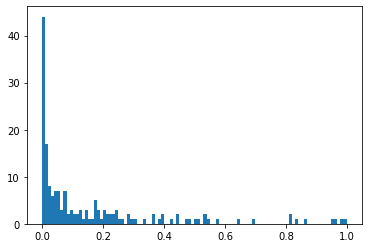

In [29]:
# plot histograms of the p-values
plt.hist(greedy19df['shuffled_pvalue'],bins=100)
plt.show()

In [39]:
# read in '../AnyNewEdgeCountSnowballedCleanedSplit100BOCCResultsCombinedFixed/2021/paris.greedy.2021.bocc_res.tsv'
g19snowballing = pd.read_csv('../AnyNewEdgeCountSnowballedCleanedSplit100BOCCResultsCombinedFixed/2019/paris.greedy.2019.bocc_res.tsv',sep='\t')

print(g19snowballing.columns)
print(g19snowballing.shape)


Index(['cluster_id', 'cluster_size', 'gene_ratio', 'HPO_ratio',
       'num_sig_go_enrichment_terms', 'sig_go_enrichment_p_vals',
       'sig_go_enrichment_fdr_corrected_p_vals', 'sig_go_enrichment_terms',
       'go_sig_threshold', 'max_norm_cell_type_specificity',
       'max_norm_cell_type_comma_sep_string', 'num_of_diseases',
       'max_norm_disease_specificity', 'max_norm_disease_comma_sep_string',
       'mg2_pairs_count', 'mg2_not_pairs_count',
       'mg2_portion_families_recovered', 'avg_embeddedness',
       'avg_internal_degree', 'conductance', 'cut_ratio', 'normalized_cut',
       'expansion', 'triangle_participation_ratio', 'surprise', 'significance',
       'newman_girvan_modularity', 'internal_edge_density', 'edges_inside',
       'hub_dominance', 'max_plof', 'mean_plof', 'median_plof', 'std_plof',
       'sum_plof', 'snowballing_pvalue', 'num_new_edges_on_any_node'],
      dtype='object')
(171, 37)


# Random Clusters


In [31]:
# load the new edges
el_pairs = load_new_edges(el='../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt', G=G19)
print('2020',len(el_pairs))
# for each cluster, get the number of members
random.seed(0)
# check if cluster_rediscoveries.pickle exists
if os.path.exists('cluster_rediscoveries.pickle'):
    print('Loading cluster rediscoveries')
    # load the pickle file
    with open('cluster_rediscoveries.pickle','rb') as f:
        cluster_rediscoveries = pickle.load(f)
else:
    print('Calculating cluster rediscoveries')
    cluster_rediscoveries = []
    for j in range(1000):
        if j % 100 == 0:
            print(j)
        cluster_rediscoveries.append([])
        for i in range(len(g_subcoms)):
            # print('Cluster',i)
            first_resample = True
            # print(i)
            size = len(g_subcoms[i].members)
            if size < 3:
                cluster_rediscoveries[-1].append(rediscoveries)
                continue
            # from G19 pick size number of nodes at random, if there nodes do not have a phenotype, then re pick
            heterozygous = False
            while not heterozygous:
                # the line above but make sure it samples without replacement
                nodes = random.choices(list(G19.nodes),k=size)
                has_hpo = any([ 'HP:' in x for x in nodes])
                has_gene = any([ 'HP:' not in x for x in nodes])
                heterozygous = has_hpo and has_gene
            random_pairs = get_possible_pairs_from_com_non_bocc(nodes, G19)
            rediscoveries = len(random_pairs.intersection(el_pairs))
            cluster_rediscoveries[j].append(rediscoveries)

    for i in range(len(cluster_rediscoveries)):
        print(i, len(cluster_rediscoveries[i]))
    with open('cluster_rediscoveries.pickle','wb') as f:
        pickle.dump(cluster_rediscoveries,f)

2020 130314
Loading cluster rediscoveries


[0, 0, 5, 0, 1, 0, 9, 0, 2, 0, 0, 0, 0, 5, 6, 2, 7, 5, 2, 0, 11, 8, 0, 0, 0, 0, 5, 1, 14, 1, 9, 0, 3, 0, 14, 1, 3, 0, 1, 0, 2, 4, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 13, 1, 5, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 8, 0, 0, 0, 0, 4, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 0, 1, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0, 11, 0, 0, 17, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0
100
200
300
400
500
600
700
800
900


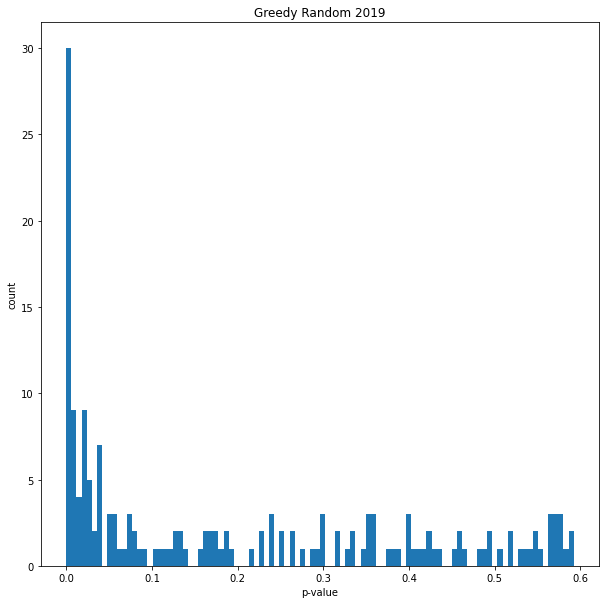

In [32]:
random.seed(0)
def random_clusters(G,current_coms,future_el,name):
    com_pairs = get_possible_pairs_from_com(current_coms, G)
    real_rediscoveries = rediscover(com_pairs, el_pairs)
    print(real_rediscoveries)
    
    future_pairs = load_new_edges(el=future_el, G=G)
    cluster_rediscoveries = []
    # for the number of iterations
    for j in range(1000):
        if j % 100 == 0:
            print(j)
        cluster_rediscoveries.append([])
        # for each cluster
        for i in range(len(current_coms)):
            # print('Cluster',i)
            first_resample = True
            # print(i)
            size = len(current_coms[i].members)
            if size < 3:
                cluster_rediscoveries[-1].append(-1)
                continue
            # from G19 pick size number of nodes at random, if there nodes do not have a phenotype, then re pick
            heterozygous = False
            while not heterozygous:
                # the line above but make sure it samples without replacement
                nodes = random.choices(list(G.nodes),k=size)
                has_hpo = any([ 'HP:' in x for x in nodes])
                has_gene = any([ 'HP:' not in x for x in nodes])
                heterozygous = has_hpo and has_gene
            random_pairs = get_possible_pairs_from_com_non_bocc(nodes, G19)
            tmp_rediscoveries = len(random_pairs.intersection(future_pairs))
            cluster_rediscoveries[j].append(tmp_rediscoveries)

    rediscovery_p_values = []
    # for each cluster
    for i in range(len(real_rediscoveries)):
        this_coms_cluster_rediscoveries = [x[i] for x in cluster_rediscoveries]
        # empirical p-value for number of times rediscovery is greater than or equal to the shuffled rediscovery
        p = 1 - (sum([1 for x in this_coms_cluster_rediscoveries if real_rediscoveries[i] >= x])/len(this_coms_cluster_rediscoveries))
        rediscovery_p_values.append(p)
    
    sub_com_names = [name + str(x.name) for x in current_coms]
    p_values_filtered_random_null = []
    sub_com_names_filtered_random_null = []
    for i in range(len(rediscovery_p_values)):
        p_values_filtered_random_null.append(rediscovery_p_values[i])
        sub_com_names_filtered_random_null.append(sub_com_names[i])
    # make a dataframe of the rediscovery p-values and cluster scores and cluster names
    random_null_df = pd.DataFrame({'random_com_p-value':p_values_filtered_random_null,
                                'cluster_name':sub_com_names_filtered_random_null})
    return random_null_df

greedy_random_19_df = random_clusters(G19,g_subcoms,'../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt','paris.greedy.2019:')

# plot the p-values as a histogram
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.hist(greedy_random_19_df['random_com_p-value'],bins=100)
ax.set_title('Greedy Random 2019')
ax.set_xlabel('p-value')
ax.set_ylabel('count')
plt.show()

     random_com_p-value            cluster_name
0                 0.018   paris.greedy.2019:164
1                 0.001   paris.greedy.2019:165
2                 0.008   paris.greedy.2019:219
3                 0.358   paris.greedy.2019:220
4                 0.078   paris.greedy.2019:221
..                  ...                     ...
166               0.005  paris.greedy.2019:1134
167               0.023  paris.greedy.2019:1138
168               0.007  paris.greedy.2019:1139
169               0.020  paris.greedy.2019:1207
170               0.001  paris.greedy.2019:1431

[171 rows x 2 columns]
snowballing p = 1: 0.695906432748538
snowballing p < 0.05: 0.05847953216374269
edge shuffle p < 0.05: 0.47953216374269003
random clusters p < 0.05: 0.391812865497076


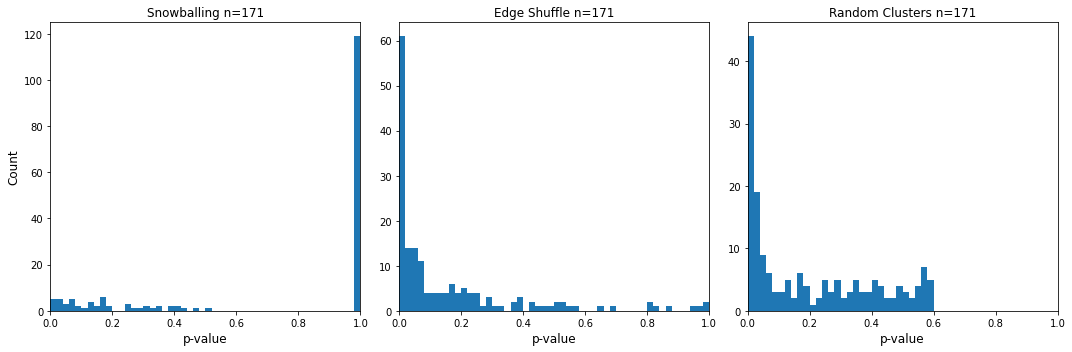

In [43]:
# plot 3 historgrams of snowballing p-values, edge shuffle and random cluster p-values

# print(random_null_df)
# print(greedy19df)
print(greedy_random_19_df)

snowballing_col = 'p-value'
edge_shuffle_col = 'shuffled_pvalue'
rand_clsuter_col = 'cluster_score'

fig, ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

ax[0].hist(g19snowballing['snowballing_pvalue'],bins=50,range=[0,1])
ax[1].hist(greedy19df['shuffled_pvalue'],bins=50,range=[0,1])
ax[2].hist(greedy_random_19_df['random_com_p-value'],bins=50,range=[0,1])
ax[0].set_xlabel('p-value',fontsize=std_fontsize)
ax[1].set_xlabel('p-value',fontsize=std_fontsize)
ax[2].set_xlabel('p-value',fontsize=std_fontsize)
ax[0].set_ylabel('Count',fontsize=std_fontsize)
ax[0].set_title('Snowballing n={}'.format(g19snowballing.shape[0]),fontsize=std_fontsize)
ax[1].set_title('Edge Shuffle n={}'.format(greedy19df.shape[0]),fontsize=std_fontsize)
ax[2].set_title('Random Clusters n={}'.format(greedy_random_19_df.shape[0]),fontsize=std_fontsize)
# ax[0].set_yscale('log')
ax[0].set_xlim([0,1])
ax[1].set_xlim([0,1])
ax[2].set_xlim([0,1])

plt.tight_layout()
plt.savefig('../PublicationFigures/null_model_hists.png',dpi=300)

# what % of cluster_scores.values() is p = 1
print('snowballing p = 1: ' + str(sum([1 for x in g19snowballing['snowballing_pvalue'] if x == 1])/len(g19snowballing['snowballing_pvalue'])))
print('snowballing p < 0.05: ' + str(sum([1 for x in g19snowballing['snowballing_pvalue'] if x < 0.05])/len(g19snowballing['snowballing_pvalue'])))

# what % of greedy19df['shuffled_pvalue'] is p = 0
print('edge shuffle p < 0.05: ' + str(sum([1 for x in greedy19df['shuffled_pvalue'] if x < 0.05])/len(greedy19df['shuffled_pvalue'])))
# what % of greedy_random_19_df['random_com_p-value'] is p = 0
print('random clusters p < 0.05: ' + str(sum([1 for x in greedy_random_19_df['random_com_p-value'] if x < 0.05])/len(greedy_random_19_df['random_com_p-value'])))

(array([ 33.,  17.,  11.,   8.,   3.,   2.,   2.,   0.,   0., 303.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

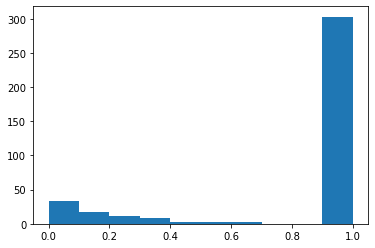

In [34]:
plt.hist(cluster_scores.values())